In [1]:
from keras.models import Sequential, Model
from keras.layers import InputLayer, Conv2D, MaxPooling2D, UpSampling2D, Resizing, Concatenate, Input
from keras.optimizers import Adam
import visualkeras

In [2]:
def build_autoencoder(input_shape):
    h, w = input_shape[:2]

    autoencoder = Sequential([
        InputLayer(shape=input_shape),

        # Encoder
        Conv2D(64, (3, 3), activation=None, padding='same'),
        MaxPooling2D((2, 2), padding='same'),
        Conv2D(32, (3, 3), activation=None, padding='same'),
        MaxPooling2D((2, 2), padding='same'),

        # Decoder
        Conv2D(32, (3, 3), activation=None, padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(64, (3, 3), activation=None, padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(3, (3, 3), activation='sigmoid', padding='same'),

        # Resize to original input shape
        Resizing(h, w)
    ])

    autoencoder.compile(optimizer=Adam(), loss="mse")
    return autoencoder

In [3]:
# === CrossEncoder definition ===
def build_crossencoder(input_shape, ae1, ae2):
    """
    Build a CrossEncoder that combines outputs of two pretrained AutoEncoders.
    ae1, ae2: pretrained single-hazard autoencoders (frozen).
    """
    
    input_img = Input(shape=input_shape)

    # Pass input through both pretrained AEs
    out1 = ae1(input_img)
    out2 = ae2(input_img)

    # Concatenate their outputs
    merged = Concatenate(axis=-1)([out1, out2])

    h, w = input_shape[:2]

    # CrossEncoder layers
    x = Conv2D(64, (3, 3), padding='same')(merged)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(32, (3, 3), padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    x = Resizing(h, w)(x)

    crossencoder = Model(input_img, x)
    crossencoder.compile(optimizer=Adam(learning_rate=0.0001), loss="mse")
    return crossencoder

In [4]:
model1 = build_autoencoder((150, 200, 3))
model2 = build_autoencoder((150, 200, 3))
model3 = build_crossencoder((150, 200, 3), model1, model2)


In [5]:
model3.layers[0].output.shape

(None, 150, 200, 3)

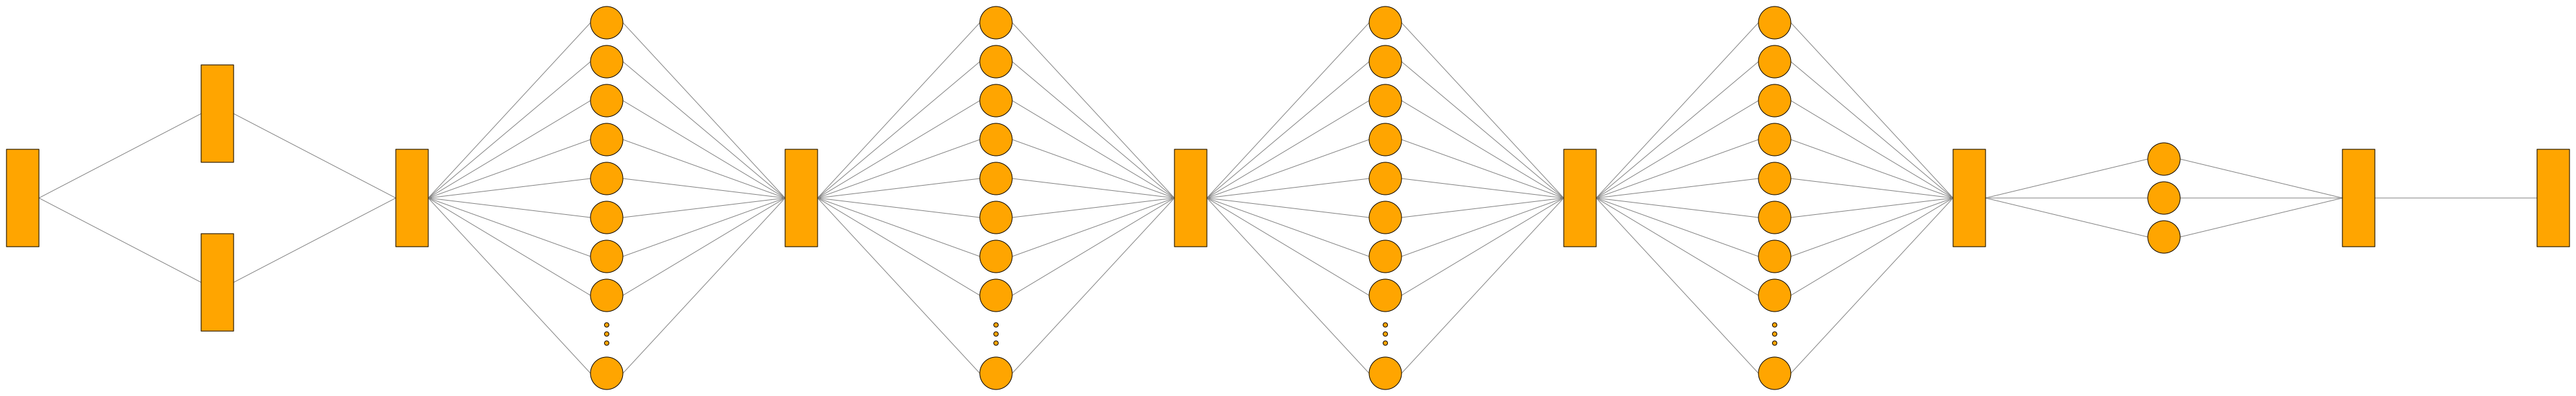

In [6]:
visualkeras.graph_view(model3)

In [7]:
def text_callable(layer_index, layer):
    # Every other piece of text is drawn above the layer, the first one below
    above = True

    # Get the output shape of the layer
    if hasattr(layer, 'output_shape'):
        # ───────────────────────────────
        # Legacy Keras (standalone 2.x) or TF-Keras <2.11
        # ───────────────────────────────
        # this will work so long as `layer.output_shape` exists
        output_shape = [x for x in list(layer.output.shape) if x is not None]
    else:
        # ───────────────────────────────
        # Modern TF-Keras (>= 2.11) – attribute removed
        # ───────────────────────────────
        output_shape = list(layer.output.shape)[1:]

    # If the output shape is a list of tuples, we only take the first one
    if isinstance(output_shape[0], tuple):
        output_shape = list(output_shape[0])
        output_shape = [x for x in output_shape if x is not None]

    # Variable to store text which will be drawn    
    output_shape_txt = ""

    # Create a string representation of the output shape
    for ii in range(len(output_shape)):
        output_shape_txt += str(output_shape[ii])
        if ii < len(output_shape) - 1: # Add an x between dimensions, e.g. 3x3
            output_shape_txt += "x"
        if ii == len(output_shape) - 1: # Add a newline between the last two dimensions, e.g. 3x3 \n 64
            output_shape_txt += "\n"

    # Add the name of the layer to the text, as a new line
    output_shape_txt += f"{layer.name}\n"

    # Return the text value and if it should be drawn above the layer
    return output_shape_txt, above

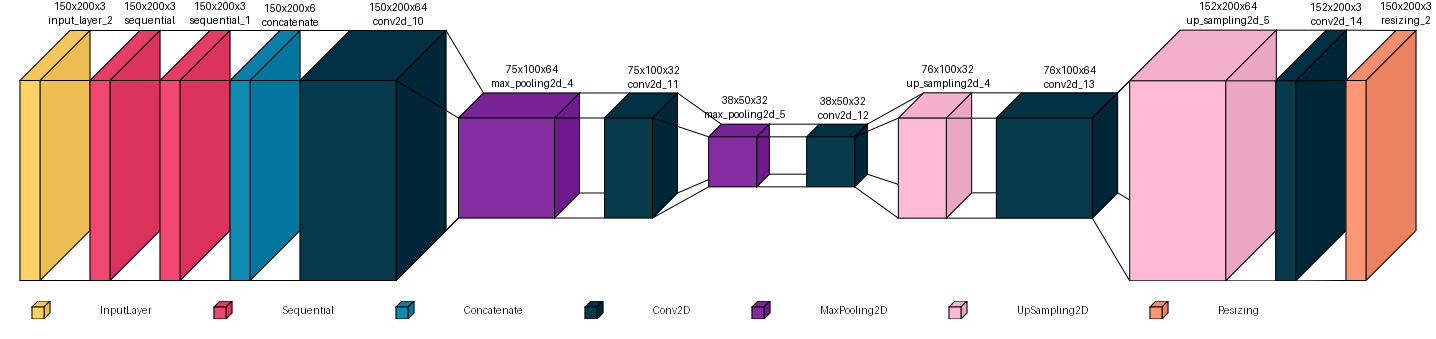

In [8]:
visualkeras.layered_view(model3, legend=True, legend_text_spacing_offset=0, text_callable=text_callable, background_fill=None, spacing=50, scale_xy = 1, to_file="model_layered_view.png", padding=20)